### Decision trees, Bagging and Random Forest - Implementation

Collaborated with - Sahil Aggarwal

In [1]:
import numpy as np
import pandas as pd

import math
from statistics import mode
import matplotlib.pyplot as plt
import random

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score


survival - Survival (0 = No; 1 = Yes)
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name - Name
sex - Sex
age - Age
sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard
ticket - Ticket Number
fare - Passenger Fare
cabin - Cabin
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat - Lifeboat (if survived)
body - Body number (if did not survive and body was recovered)



## Exploring the Data

In [2]:
# First few rows

titanic = pd.read_csv("titanic.csv.bz2")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
#Columns
titanic.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [1]:
#Checking codding of variables

In [6]:
titanic.pclass.unique()

array([1, 2, 3], dtype=int64)

In [7]:
titanic.sex.unique()

array(['female', 'male'], dtype=object)

In [8]:
titanic.sibsp.unique()

array([0, 1, 2, 3, 4, 5, 8], dtype=int64)

In [9]:
titanic.parch.unique()

array([0, 2, 1, 4, 3, 5, 6, 9], dtype=int64)

In [10]:
titanic.embarked.unique()

array(['S', 'C', nan, 'Q'], dtype=object)

In [11]:
titanic['boat'].unique()

array(['2', '11', nan, '3', '10', 'D', '4', '9', '6', 'B', '8', 'A', '5',
       '7', 'C', '14', '5 9', '13', '1', '15', '5 7', '8 10', '12', '16',
       '13 15 B', 'C D', '15 16', '13 15'], dtype=object)

In [12]:
titanic.survived.unique()

array([1, 0], dtype=int64)

In [13]:
# Filling Nan values for embarked with mode

e = mode(titanic['embarked'])
titanic['embarked'] = titanic['embarked'].fillna(e)

In [14]:

# Encoding string categorical values for embarked and sex

encoder = LabelEncoder()
titanic['embarked'] = encoder.fit_transform(titanic['embarked'])

# Using list comprehension for sex

titanic['sex'] = [0 if i=='male' else 1 for i in titanic.sex]

In [15]:
# Computing summary statistics

cols=['pclass','age','sibsp','parch','fare',"body","sex",'embarked']
survived=[]
drowned=[]
missing = []
for i in cols:
    survived.append(titanic[titanic.survived==1][i].mean())
    drowned.append(titanic[titanic.survived==0][i].mean())
    missing.append(titanic[i].isnull().sum())

In [16]:
summary_stats = pd.DataFrame()

In [17]:
summary_stats['cols']=cols
summary_stats['survived']=survived
summary_stats['drowned']=drowned
summary_stats['missing_values']=missing

In [18]:
summary_stats

,cols,survived,drowned,missing_values
0,pclass,1.962000,2.500618,0
1,age,28.918228,30.545369,263
2,sibsp,0.462000,0.521632,0
3,parch,0.476000,0.328801,0
4,fare,49.361184,23.353831,1
5,body,NaN,160.809917,1188
6,sex,0.678000,0.156984,0
7,embarked,1.312000,1.605686,0


In [19]:
# Filling missing values for age with the mean

titanic['age'] = titanic.age.fillna(titanic.age.mean())

## Implement the decision tree 

In [21]:
# Defining X and Y
X_data = titanic[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex','embarked']]
Y_data = titanic['survived']

In [22]:
# Splitting the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.20, random_state=42)

In [23]:
# Defining the training set and the test set

training_set = pd.concat([X_train,y_train],axis=1)
test_set = pd.concat([X_test,y_test],axis=1)

In [24]:
def entropy(length_survived,length_drowned):
    """
    Takes in the length of survived and drowned people and calculates entropy
    """
    sum = length_survived + length_drowned

    entropy = 0
    
    #Calculate probability
    p = length_survived / sum
    if (p != 0):
        entropy += p * math.log(p, 2)
    p = (length_drowned)/sum
    if (p != 0):
        entropy += p * math.log(p, 2)

    e = -entropy
    return e

In [25]:
def information_gain(data,feature):

    gain = 0
    shape = data.shape[0]
      for i in data[feature].unique():
        feature_data = data[data[feature] == i]
        weight = len(feature_data)
        a = len(feature_data[feature_data['survived'] == 1])
        b = len(feature_data[feature_data['survived'] == 0])
        gain = gain + ((calc_entropy(a, b))*weight/shape)
    
    return gain

In [26]:
# Calculate the entropy of age for the best split from age vector

def entropy_age(dataset):    
    survived = dataset[dataset.survived==1].shape[0]
    total = dataset.shape[0];

    entropy = 0
    p = survived / total
    if (p != 0):
        entropy += p * math.log(p, 2)
    p = (total - survived)/total
    if (p != 0):
        entropy += p * math.log(p, 2)

    entropy = -entropy
    return entropy

age = np.unique(X_train['age'])
age = age[~np.isnan(age)]


# Finding the entropy for the first value of age vector

a = training_set[training_set.age<=age[0]]
b = training_set[training_set.age>age[0]]
entropy = ((a.shape[0]/(a.shape[0]+b.shape[0]))*entropy_age(a))  +  ((b.shape[0]/(a.shape[0]+b.shape[0]))*entropy_age(b))
entropy 

0.945246650784105

In [27]:
entropy  = pd.DataFrame(columns = ['Value', 'H(S)'])

#Iterating over each value of age
for i in age:
    # Splitting age according to threshold in this iteration
    training_set['age*'] = np.where(training_set['age'] > i, 1,0)
    
    # Finding entropy of age column
    gain = information_gain(training_set, 'age*')
    
    idx = len(entropy) + 1
    
    entropy.loc[idx] = [i, gain]

entropy[entropy['Value']==8]

,Value,H(S)
14,8.0,0.932815


Best value to split age is 8, i.e age=8 gives the lowest entropy

In [28]:
entropy  = pd.DataFrame(columns = ['Value', 'H(S)'])

for i in training_set.pclass.unique():

    training_set['pclass*'] = np.where(training_set['pclass'] > i, 1,0)
    gain = information_gain(training_set, 'pclass*')
    
    idx = len(entropy) + 1
    
    entropy.loc[idx] = [i, gain]

entropy.sort_values(by='H(S)')


,Value,H(S)
2,2.0,0.894528
3,1.0,0.896097
1,3.0,0.946637


Pclass = 2 has the lowest entropy and hence is the best boundary to split for pclass

In [29]:
# drop uneccesary cols
training_set = training_set.drop(['age*','pclass*'],axis=1)
training_set.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked',
       'survived'],
      dtype='object')

In [31]:
#Calculate best split

cols = ['pclass', 'sex','age','sibsp','embarked']
result = pd.DataFrame(columns = ['feature', 'entropy', 'value'])
for i in cols:
        for elem in training_set[i].unique():
            training_set['class'] = np.where(training_set[i] > elem, 1,0)
            en = information_gain(training_set, 'class')
            idx = len(result) + 1
            result.loc[idx] = [i,en,elem]
result.sort_values(by='entropy').head(21)

,feature,entropy,value
4,sex,0.736954,0
2,pclass,0.894528,2
3,pclass,0.896097,1
109,embarked,0.923385,0
110,embarked,0.930889,1
52,age,0.932815,8
12,age,0.933450,9
31,age,0.933602,5
90,age,0.933683,7
45,age,0.934535,6


In [32]:
def split_data(data, cols):
    #Splits the data based on the best split boundary for a variable
    result  = pd.DataFrame(columns = ['feature', 'entropy', 'value'])
    for i in cols:
        for elem in data[i].unique():
            data['class'] = np.where(data[i] > elem, 1,0)
            en = information_gain(data, 'class')
            idx = len(result) + 1
            result.loc[idx] = [i,en,elem]
    return(result[result['entropy'] == result['entropy'].min()])

In [33]:
split(training_set,['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked'])

,feature,entropy,value
377,sex,0.736954,0


In [34]:
def percentage_survived(data):
    """
    a function that prints the percentage of survived and not survived on each branch given data and split point
    """
    
    if(len(data['survived'].unique()) > 0):
        a = len(data[data['survived'] == 1])/len(data)*100
        b = len(data[data['survived'] == 0])/len(data)*100
    
    else:   
        if(data['survived'].unique() == 0):
            a = 100
            b = 0
        else:
            a = 100
            b = 0

    return(a, b)

In [35]:
training_set = training_set.drop('class',axis=1)

In [36]:
training_set = training_set.dropna()

In [38]:
# Making a tree to store the values which return from growTree
result_tree = pd.DataFrame(columns = ['node', 'observation', 'Survived', 'Drowned', 'feature', 'value'])

In [39]:
def growTree(data, path):
    """
    A recursive function that implements the decision tree model and stores it in a dataframe
    where "root" signifies root, "L" signifies left node and "R" signifies right node.
    """
    #Drop the survived coloumn from the list of cols
    cols = data.columns.drop(['survived'])
    
    #Split on the best boundary for the lowest entropy feature
    a = split(data, cols)
    
    if(np.shape(a)[0]>1):
        return(1)
    
    #Calculating the percentage of people survived and drowned at every step
    survived, drowned = percentage_survived(data)
    
    feature = a['feature'].item()
    best_value = a['value'].item()
    
    # Defining the left and right branch
    data_left = data[data[feature] > best_value]
    data_right = data.drop(index = data_left.index)
    
    #Populating the final dataset
    idx = len(result_tree) + 1
    result_tree.loc[idx] = [path, len(data),survived, drowned, feature, best_value]
    
    #Setting the stoping criterion
    if(survived == 0 or drowned == 0):
        idx = len(result_tree) + 1
        pathleaf = path + 'leaf'
        result_tree.loc[idx] = [pathleaf, len(data),survived, drowned, feature, best_value]
        return(1)
    else:
        pathl = path + 'L'
        pathr = path + 'R'
        growTree(data_left, pathl)
        growTree(data_right, pathr)  



In [40]:
growTree(training_set, 'root')

C:\Users\prate\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [41]:
result_tree[result_tree['node']=='root']

,node,observation,Survived,Drowned,feature,value
1,r,1046,36.520076,63.479924,sex,0


In [42]:
result_tree[result_tree['node']=='rootL']

,node,observation,Survived,Drowned,feature,value
2,rL,370,71.351351,28.648649,pclass,2


In [43]:
result_tree[result_tree['node']=='rootR']

,node,observation,Survived,Drowned,feature,value
37,rR,676,17.455621,82.544379,age,9


In [44]:
result_tree[result_tree['node']=='rootLL']

,node,observation,Survived,Drowned,feature,value
3,rLL,175,46.857143,53.142857,fare,23.25


In [45]:
result_tree[result_tree['node']=='rootLR']

,node,observation,Survived,Drowned,feature,value
23,rLR,195,93.333333,6.666667,fare,31.6792


In [46]:
result_tree[result_tree['node']=='rootRL']

,node,observation,Survived,Drowned,feature,value
38,rRL,641,15.132605,84.867395,pclass,1


In [47]:
result_tree[result_tree['node']=='rootRR']

,node,observation,Survived,Drowned,feature,value
71,rRR,35,60.0,40.0,sibsp,2


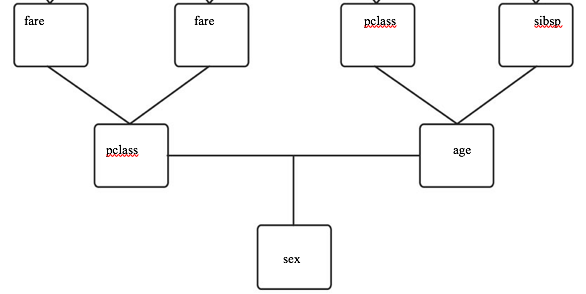

In [48]:
training_set = training_set.drop('class',axis=1)

In [49]:
# Prediction function for the decision tree
path = 'root'
def prediction(row, path):
    r = result_tree[result_tree['node'] == path]

    if(len(r.index) == 0):
        path = path[:-1]
        r = result_tree[result_tree['node'] == path]
        x = np.where(r['Survived'].item() > r['Drowned'].item(), 1, 0)
        return(x.item())
    
    else:
        if(row[r['feature'].item()].item() > r['value'].item()):
            path = path + 'L'
            return(prediction(row, path))
        
        else:
            path = path + 'R'
            return(prediction(row, path))

In [50]:
# Checking on the test set

results = []

for elem in test_set.iterrows():
    temp = pd.DataFrame(list(elem)[1:], columns = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked'])
    path = 'r'
    t = prediction(temp, 'r')
    results.append(t)

len(results)

262

In [51]:
test_set['p'] = results

In [52]:
(accuracy_score(test_set['survived'],test_set['p']))*100

75.19083969465649

In [53]:
precision_score(test_set['survived'],test_set['p'])

0.8271604938271605

In [54]:
recall_score(test_set['survived'],test_set['p'])

0.5677966101694916

## Bagging and Random Forest

### Bagging

In [55]:
# Doing for 5 bags with N samples each from a training set of N samples where N = 262

# defining a dataframe for bagging to store results
bagging = pd.DataFrame(columns = ['bag1', 'bag2','bag3','bag4','bag5'])


for elem in bagging.columns:
    
    #Defining a tree to store decision tree results for each individual bag
    result_tree = pd.DataFrame(columns = ['node', 'observation', 'Survived', 'Drowned', 'feature', 'value'])
    
    #Drawing 300 samples with replacement
    bag_train = training_set.sample(n=300, replace = True)
    
    #Running decision tree to populate result_tree dataframe
    growTree(bag_train, 'r')
    
    result = []
    
    d_final_test = test_set[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked']].dropna()
    
    #Making predictions on the test set
    for e in d_final_test.iterrows():
        temp = pd.DataFrame(list(e)[1:], columns = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked'])
        t = prediction(temp,'r')
        result.append(t)
    #Populating the bagging dataset with predictions for each bag    
    bagging[elem] = result

C:\Users\prate\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [56]:
# Predictions for each bag
bagging.head(15)

,bag1,bag2,bag3,bag4,bag5
0,0,0,1,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,1,0,0,0,0
6,0,0,0,0,0
7,0,0,0,0,0
8,0,0,0,0,0
9,1,1,1,1,1


In [57]:
bagging['majority']=''

In [58]:
# Finding majority values for each bag using mode

for i in range(0,len(bagging)):
    bagging['majority'].iloc[i] = mode(list(bagging.iloc[i])[0:5])

C:\Users\prate\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [59]:
bagging.tail(10)

,bag1,bag2,bag3,bag4,bag5,majority
252,1,0,1,0,0,0
253,1,1,1,1,1,1
254,0,0,0,0,0,0
255,0,0,0,0,0,0
256,0,0,0,0,1,0
257,1,1,1,1,1,1
258,0,0,0,0,0,0
259,1,0,1,0,0,0
260,0,0,0,0,1,0
261,1,1,1,1,1,1


In [60]:
(accuracy_score(test_set['survived'],bagging['majority']))*100

70.99236641221374

In [61]:
precision_score(test_set['survived'],bagging['majority'])

0.8088235294117647

In [62]:
recall_score(test_set['survived'],bagging['majority'])

0.4661016949152542

There is a very slight change in accuracy on B=5 but is not very significant.

Extending this for B between 1 and 10. The code is computationally heavy and breaks my machine if I go over 10. (Discussed with professor)

In [63]:
bags = [6,8,10]
acc=[]
p=[]
r=[]
for x in bags:
    print('Bags:',x+1)
    cols = []
    for i in (range(0,x)):
        a = 'bag'+str(i)
        cols.append(a)

    bagging = pd.DataFrame(columns = cols)

    for elem in bagging.columns:
        
        #Defining a tree to store decision tree results for each individual bag
        result_tree = pd.DataFrame(columns = ['node', 'observation', 'Survived', 'Drowned', 'feature', 'value'])

        #Drawing N samples with replacement from N observations
        bag_train = training_set.sample(n=len(training_set), replace = True)

        #Running decision tree to populate result_tree dataframe
        growTree(bag_train, 'r')
        
        print(result_tree.head(3))
        
        result = []

        d_final_test = test_set[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked']].dropna()

        #Making predictions on the test set
        for e in d_final_test.iterrows():
            temp = pd.DataFrame(list(e)[1:], columns = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked'])
            t = prediction(temp,'r')
            result.append(t)
        #Populating the bagging dataset with predictions for each bag    
        bagging[elem] = result
    
    bagging['majority']=''
    #Finding majority for each bag across one particular observation
    for j in range(0,len(bagging)):
       
        bagging['majority'].iloc[j] = mode(list(bagging.iloc[j])[0:(x+1)])
    
    #Performnace measures
    x = accuracy_score(test_set['survived'],bagging['majority'])*100
    y = precision_score(test_set['survived'],bagging['majority'])
    z = recall_score(test_set['survived'],bagging['majority'])
    
    #Append accuracy score, precision, recall for each value of B from bags
    acc.append(x)
    print('Accuracy',x)
    p.append(y)
    print('Precision',y)
    r.append(z)
    print('Recall',z)
    

Bags: 6


C:\Users\prate\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


  node observation   Survived    Drowned feature  value
1    r        1046  36.998088  63.001912     sex      0
2   rL         398  73.869347  26.130653  pclass      2
3  rLL         186  51.612903  48.387097    fare  23.25
  node observation   Survived    Drowned feature  value
1    r        1046  36.042065  63.957935     sex      0
2   rL         392  68.367347  31.632653  pclass      2
3  rLL         189  42.857143  57.142857    fare  23.25
  node observation   Survived    Drowned   feature value
1    r        1046  35.659656  64.340344       sex     0
2   rL         354  71.468927  28.531073    pclass     2
3  rLL         164  49.390244  50.609756  embarked     1
  node observation   Survived    Drowned feature  value
1    r        1046  37.762906  62.237094     sex      0
2   rL         358  74.022346  25.977654  pclass      2
3  rLL         175  53.714286  46.285714    fare  23.25
  node observation   Survived    Drowned feature   value
1    r        1046  36.615679  63.384321   

C:\Users\prate\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Accuracy 79.00763358778626
Precision 0.8181818181818182
Recall 0.6864406779661016
Bags: 8
  node observation   Survived    Drowned   feature value
1    r        1046  35.372849  64.627151       sex     0
2   rL         360  65.833333  34.166667    pclass     2
3  rLL         175  36.571429  63.428571  embarked     0
  node observation   Survived    Drowned feature    value
1    r        1046  35.564054  64.435946     sex        0
2   rL         371  72.776280  27.223720  pclass        2
3  rLL         171  50.292398  49.707602    fare  22.3583
  node observation   Survived    Drowned feature    value
1    r        1046  35.850860  64.149140     sex        0
2   rL         377  70.026525  29.973475  pclass        2
3  rLL         191  45.549738  54.450262    fare  31.3875
  node observation   Survived    Drowned feature  value
1    r        1046  38.145315  61.854685     sex      0
2   rL         384  75.260417  24.739583  pclass      2
3  rLL         186  53.763441  46.236559    fare  

In [70]:
acc = [value/100 for value in acc]

In [65]:
p

[0.8181818181818182, 0.8611111111111112, 0.8356164383561644]

In [66]:
r

[0.6864406779661016, 0.5254237288135594, 0.5169491525423728]

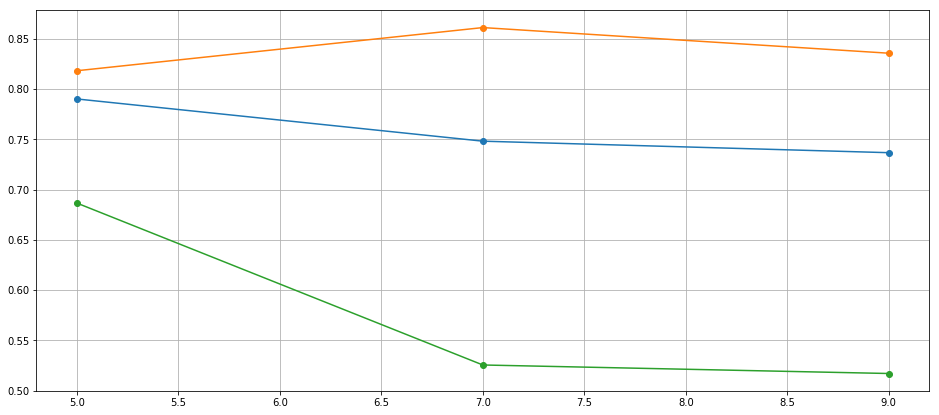

In [73]:
plt.figure(figsize=(16,7))
plt.plot(bags,acc,marker='o')
plt.plot(bags,p,marker='o')
plt.plot(bags,r,marker='o')
plt.grid(b=True)
plt.show()

According to my calculations, the accuracy should increase upto 50 bags and then remain constant for a while and the best optimal solution would be at B~150. There is however no significant increase in the accuracy with bagging.

### Random Forest 

In [166]:
training_set = pd.concat([X_train,y_train],axis=1)
test_set = pd.concat([X_test,y_test],axis=1)

In [167]:
training_set.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked',
       'survived'],
      dtype='object')

In [168]:
# growForest
forest = [6,8,10]
acc=[]
p=[]
r=[]
for x in forest:
    print('Forest with trees =',x+1)
    cols = []
    for i in (range(0,x)):
        a = 'bag'+str(i)
        cols.append(a)

    bagging = pd.DataFrame(columns = cols)

    for elem in bagging.columns:
        
        #Defining a tree to store decision tree results for each individual bag
        result_tree = pd.DataFrame(columns = ['node', 'observation', 'Survived', 'Drowned', 'feature', 'value'])
       
        cols1 = training_set.columns
        cols1 = cols1[cols1 != 'survived']
        
        #Selecting random number of features m = sqrt.(p)
        list_cols = (np.random.choice(cols1, size=int(round(math.sqrt(len(cols1)),0)), replace = False))
        list_cols = list(np.append(list_cols, 'survived'))
        
        #Subsetting the dataset
        set_train = training_set[list_cols]
               
        
        #Drawing N samples with replacement from N observations
        bag_train = set_train.sample(n=len(set_train), replace = True)
        
        #Running decision tree to populate result_tree dataframe
        growTree(bag_train, 'r')
        
        print(result_tree.head(3))

        result = []

        d_final_test = test_set[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked']].dropna()

        #Making predictions on the test set
        for e in d_final_test.iterrows():
            temp = pd.DataFrame(list(e)[1:], columns = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked'])
            t = prediction(temp,'r')
            result.append(t)
        #Populating the bagging dataset with predictions for each bag    
        bagging[elem] = result
    
    bagging['majority']=''
    #Finding majority for each bag across one particular observation
    for j in range(0,len(bagging)):
        bagging['majority'].iloc[j] = mode(list(bagging.iloc[j])[0:(x+1)])
    
    #Performnace measures
    x = accuracy_score(test_set['survived'],bagging['majority'])
    y = precision_score(test_set['survived'],bagging['majority'])
    z = recall_score(test_set['survived'],bagging['majority'])
    
    #Append accuracy score, precision, recall for each value of B from bags
    acc.append(x)
    print('Accuracy',x)
    p.append(y)
    print('Precision',y)
    r.append(z)
    print('Recall',z)
    

Forest with trees = 6


C:\Users\prate\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


  node observation   Survived    Drowned feature  value
1    r        1047  36.198663  63.801337     sex      0
2   rL         385  70.649351  29.350649    fare  69.55
3  rLR         321  64.797508  35.202492    fare   8.85
  node observation   Survived    Drowned   feature value
1    r        1047  33.237822  66.762178       sex     0
2   rL         353  66.855524  33.144476  embarked     0
3  rLL         287  62.020906  37.979094     parch     3
  node observation   Survived    Drowned feature value
1    r        1047  35.816619  64.183381  pclass     1
2   rL         794  27.959698  72.040302   parch     0
3  rLL         202  45.049505  54.950495  pclass     2
  node observation   Survived    Drowned feature    value
1    r        1047  37.631328  62.368672    fare   52.000
2   rL         173  72.254335  27.745665   sibsp    3.000
3  rLR         169  73.964497  26.035503    fare  227.525
  node observation   Survived    Drowned   feature value
1    r        1047  35.148042  64.85195

C:\Users\prate\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Accuracy 0.7137404580152672
Precision 0.8115942028985508
Recall 0.4745762711864407
Forest with trees = 8
  node observation   Survived    Drowned feature  value
1    r        1047  35.530086  64.469914     sex   0.00
2   rL         371  71.428571  28.571429  pclass   2.00
3  rLL         177  50.847458  49.152542    fare  24.15
  node observation   Survived    Drowned feature     value
1    r        1047  36.676218  63.323782    fare   15.1000
2   rL         512  52.343750  47.656250    fare   77.2875
3  rLL          90  73.333333  26.666667    fare  146.5208
  node observation   Survived    Drowned   feature value
1    r        1047  35.148042  64.851958    pclass     2
2   rL         567  21.164021  78.835979       age     9
3  rLL         522  18.390805  81.609195  embarked     1
  node observation   Survived    Drowned feature value
1    r        1047  37.153773  62.846227     sex     0
2   rL         380  72.368421  27.631579   sibsp     2
3  rLL          24  25.000000  75.000000  

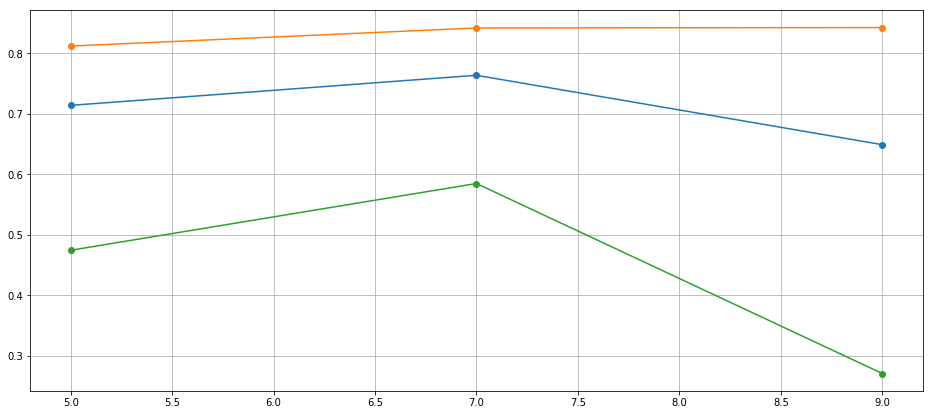

In [169]:
plt.figure(figsize=(16,7))
plt.plot(forest,acc,marker='o')
plt.plot(forest,p,marker='o')
plt.plot(forest,r,marker='o')
plt.grid(b=True)
plt.show()

The best optimal value for Random forest would be around 150. However my machine did not allow this computation, but as suggested by Professor, on running for 10 tress we can see an improve in accuracy. The accuracy is better than bagging but overall there is no significant increase in accuracy. The Precision however is much better than bagging and one decision tree 